# Data Source and goal of this case study

Data: https://www.kaggle.com/patrickb1912/ipl-complete-dataset-20082020  
          
Goal:   
    1. Identify cluster of players with similar performance  
    2. Given a player name, identify similar players  
    3. Create a best team with mix of batsman, bowler, allrounders & wicket-keeper
    

# Imports and data read

In [97]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN

In [3]:
balldf = pd.read_csv("data/IPL_2008_2020/IPL Ball-by-Ball 2008-2020.csv")

In [4]:
matches = pd.read_csv("data/IPL_2008_2020/IPL Matches 2008-2020.csv")

In [5]:
balldf.head()

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


In [6]:
balldf.shape

(193468, 18)

In [7]:
matches.head()

,id,city,date,player_of_match,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,Bangalore,2008-04-18,BB McCullum,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,Chandigarh,2008-04-19,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,Delhi,2008-04-19,MF Maharoof,Feroz Shah Kotla,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,Mumbai,2008-04-20,MV Boucher,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper
4,335986,Kolkata,2008-04-20,DJ Hussey,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan


# Check Missing

# Create batsman statistics

## Variables by grouping on batsman

In [8]:
batgroup = balldf.groupby(['batsman'])

In [9]:
batdf = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'balls_faced'})
batdf['innings'] = batgroup['id'].nunique()
batdf['runs'] = batgroup['batsman_runs'].sum()
batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
batdf['6s'].fillna(0,inplace=True)




In [10]:
display(batdf.tail())

,balls_faced,innings,runs,4s,6s
batsman,,,,,
YV Takawale,183,10,192,26.0,3.0
Yashpal Singh,67,4,47,5.0,0.0
Younis Khan,7,1,3,0.0,0.0
Yuvraj Singh,2205,126,2750,217.0,149.0
Z Khan,141,27,117,11.0,2.0


## Derived variable - Batsman strike rate

# Create bowler statistics

## Variables by grouping on bowler

In [11]:
bowlgroup = balldf.groupby(['bowler'])

In [16]:
balldf['dismissal_kind'].unique()

array([nan, 'caught', 'run out', 'bowled', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field'], dtype=object)

In [23]:
bowldf = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ball'].count()
bowldf['wickets'].fillna(0,inplace=True)
# batdf['innings'] = batgroup['id'].nunique()
# batdf['runs'] = batgroup['batsman_runs'].sum()
# batdf['4s'] = balldf[balldf['batsman_runs'] == 4].groupby('batsman')['batsman_runs'].count()
# batdf['4s'].fillna(0,inplace=True)
# batdf['6s'] = balldf[balldf['batsman_runs'] == 6].groupby('batsman')['batsman_runs'].count()
# batdf['6s'].fillna(0,inplace=True)

bowldf.head()


,balls_bowled,wickets
bowler,,
A Ashish Reddy,270,18.0
A Chandila,234,11.0
A Choudhary,108,5.0
A Dananjaya,25,0.0
A Flintoff,66,2.0


## Derived variable - Bowler econ rate

# Create no. of catches statistics

# Number of man of the  matches from matches file

# Merge to player statistics

In [43]:
players = pd.merge(batdf,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [44]:
players.tail()

,balls_faced,innings,runs,4s,6s,balls_bowled,wickets
YV Takawale,183.0,10.0,192.0,26.0,3.0,0.0,0.0
Yashpal Singh,67.0,4.0,47.0,5.0,0.0,0.0,0.0
Younis Khan,7.0,1.0,3.0,0.0,0.0,0.0,0.0
Yuvraj Singh,2205.0,126.0,2750.0,217.0,149.0,882.0,36.0
Z Khan,141.0,27.0,117.0,11.0,2.0,2276.0,102.0


# Scale the data

In [69]:
# instantiate
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()


# TESTING -  CONSIDER  ONLY RUNS AND WICKETS
players_scaled  = players_scaled[['runs','wickets']]


# players_scaled.columns=players.columns

In [70]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

,runs,wickets
count,5.800000e+02,5.800000e+02
mean,1.837611e-17,5.589399e-17
std,1.000863e+00,1.000863e+00
min,-4.608846e-01,-5.389693e-01
25%,-4.508581e-01,-5.389693e-01
50%,-3.996114e-01,-4.297824e-01
75%,-1.411495e-01,5.245993e-02
max,6.087559e+00,5.648291e+00


# Finding optimal no. of clusters

## Elbow method

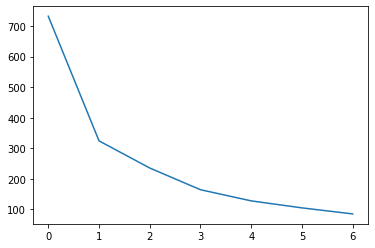

In [71]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(players_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

## Silhouette Analysis¶
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [72]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(players_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(players_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.6808866250299331
For n_clusters=3, the silhouette score is 0.7281795592571398
For n_clusters=4, the silhouette score is 0.6758473189844609
For n_clusters=5, the silhouette score is 0.6529549887587791
For n_clusters=6, the silhouette score is 0.6159039764683353
For n_clusters=7, the silhouette score is 0.6168103737057268
For n_clusters=8, the silhouette score is 0.6211674809166047


In [73]:
NUM_CLUSTERS = 3

# k-means Clustering

In [92]:
# final model with k=3
kmeans = KMeans(n_clusters=NUM_CLUSTERS, max_iter=50)
kmeans.fit(players_scaled)

# assign the label
players['cluster_kmeans'] = kmeans.labels_
players.head()

,balls_faced,innings,runs,4s,6s,balls_bowled,wickets,cluster_labels_hier,cluster_id_kmeans,cluster_kmeans
A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,270.0,18.0,0,0,0
A Chandila,7.0,2.0,4.0,0.0,0.0,234.0,11.0,0,0,0
A Chopra,75.0,6.0,53.0,7.0,0.0,0.0,0.0,0,0,0
A Choudhary,20.0,3.0,25.0,1.0,1.0,108.0,5.0,0,0,0
A Dananjaya,5.0,1.0,4.0,0.0,0.0,25.0,0.0,0,0,0


# Hierarchical Clustering

## Dendogram

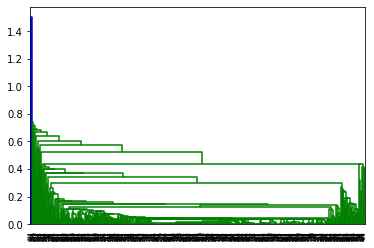

In [75]:
# single linkage
mergings = linkage(players_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

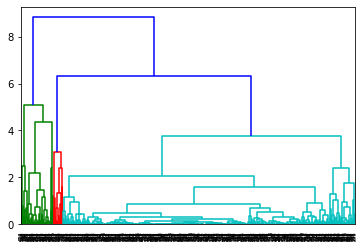

In [76]:
# complete linkage
mergings = linkage(players_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [77]:
# Create the cluster labels
cluster_labels = cut_tree(mergings, n_clusters=NUM_CLUSTERS).reshape(-1, )

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,

In [93]:
# assign cluster labels
players['cluster_hier'] = cluster_labels
players

,balls_faced,innings,runs,4s,6s,balls_bowled,wickets,cluster_labels_hier,cluster_id_kmeans,cluster_kmeans,cluster_hier
A Ashish Reddy,196.0,23.0,280.0,16.0,15.0,270.0,18.0,0,0,0,0
A Chandila,7.0,2.0,4.0,0.0,0.0,234.0,11.0,0,0,0,0
A Chopra,75.0,6.0,53.0,7.0,0.0,0.0,0.0,0,0,0,0
A Choudhary,20.0,3.0,25.0,1.0,1.0,108.0,5.0,0,0,0,0
A Dananjaya,5.0,1.0,4.0,0.0,0.0,25.0,0.0,0,0,0,0
A Flintoff,57.0,3.0,62.0,5.0,2.0,66.0,2.0,0,0,0,0
A Kumble,49.0,15.0,35.0,3.0,0.0,983.0,45.0,0,0,0,0
A Mishra,410.0,54.0,362.0,29.0,5.0,3233.0,160.0,1,2,1,1
A Mithun,26.0,6.0,34.0,4.0,1.0,312.0,7.0,0,0,0,0
A Mukund,23.0,2.0,19.0,1.0,0.0,0.0,0.0,0,0,0,0


0    484
2     48
1     48
Name: cluster_kmeans, dtype: int64

0    507
2     57
1     16
Name: cluster_hier, dtype: int64

#  DBScan Clustering

In [116]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(players_scaled)
labels = db.labels_

# assign cluster labels
players['cluster_dbscan'] = labels


In [117]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 42


# Comparing clustering results

In [118]:
print(f"K-means clustering with k={NUM_CLUSTERS}")
print(players['cluster_kmeans'].value_counts())
print(f"\nHierarchical clustering with k={NUM_CLUSTERS}")
print(players['cluster_hier'].value_counts())
print(f"\nDBScan clustering")
print(players['cluster_dbscan'].value_counts())

K-means clustering with k=3
0    484
2     48
1     48
Name: cluster_kmeans, dtype: int64

Hierarchical clustering with k=3
0    507
2     57
1     16
Name: cluster_hier, dtype: int64

DBScan clustering
 0    503
-1     42
 1     25
 3      5
 2      5
Name: cluster_dbscan, dtype: int64
